## **Identifying Fraudulent Transactions:**  

**Objective of the Project:**

The objective of this project is to build a predictive model that classifies whether a given transaction is fraudulent or legitimate.

Detecting fraudulent transactions is critical in the financial and banking sectors to minimize monetary losses, protect customers, and maintain trust.

**Business Goal:**

Maximize fraud detection accuracy (high recall) while maintaining a low false positive rate (balanced precision-recall trade-off).


I imported the jsonlines library because the data is stored in Json Lines format, where each line was a separate JSON object.
This library helps read and process the data easily and efficiently, especially when working with large files.

In [1]:
pip install jsonlines


In [17]:
import jsonlines
import pandas as pd
from datetime import datetime
#import sys
#print(sys.executable)

data = []

with jsonlines.open("/content/transactions data.txt") as reader:
  for obj in reader.iter(skip_invalid=True): # Used Skip_invalid as True to ignore any error related to extra characters after valid JSON Object
    data.append(obj)

data = pd.DataFrame(data)



## **Data Over View and Cleaning**:

In [18]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51417 entries, 0 to 51416
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountNumber             51417 non-null  object 
 1   customerId                51417 non-null  object 
 2   creditLimit               51417 non-null  float64
 3   availableMoney            51417 non-null  float64
 4   transactionDateTime       51417 non-null  object 
 5   transactionAmount         51417 non-null  float64
 6   merchantName              51417 non-null  object 
 7   acqCountry                51417 non-null  object 
 8   merchantCountryCode       51417 non-null  object 
 9   posEntryMode              51417 non-null  object 
 10  posConditionCode          51417 non-null  object 
 11  merchantCategoryCode      51417 non-null  object 
 12  currentExpDate            51417 non-null  object 
 13  accountOpenDate           51417 non-null  object 
 14  dateOf

In [19]:
# Count unique values in each column
unique_counts = data.nunique()

# Display the result
print("Unique value count per column:")
print(unique_counts)

Unique value count per column:
accountNumber                 367
customerId                    367
creditLimit                    10
availableMoney              45755
transactionDateTime         51376
transactionAmount           25267
merchantName                 2248
acqCountry                      5
merchantCountryCode             5
posEntryMode                    6
posConditionCode                4
merchantCategoryCode           19
currentExpDate                165
accountOpenDate               329
dateOfLastAddressChange       457
cardCVV                       396
enteredCVV                    560
cardLast4Digits               516
transactionType                 4
echoBuffer                      1
currentBalance              45337
merchantCity                    1
merchantState                   1
merchantZip                     1
cardPresent                     2
posOnPremises                   1
recurringAuthInd                1
expirationDateKeyInMatch        2
isFraud          

#### **Missing Values and Empty Strings**:
The dataset was first checked for missing values using the isnull().sum() method.
Additionally, some columns contained empty strings or whitespace characters instead of actual null values. Regular expressions (Regex) were used to detect and handle such columns appropriately.

In [20]:
# Check remaining missing values
missing_summary = data.isnull().sum()
print(missing_summary)

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


In [21]:
import numpy as np

empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()
print(empty_counts_sum[empty_counts_sum > 0])


acqCountry               280
merchantCountryCode       47
posEntryMode             287
posConditionCode          30
transactionType           45
echoBuffer             51417
merchantCity           51417
merchantState          51417
merchantZip            51417
posOnPremises          51417
recurringAuthInd       51417
dtype: int64


/tmp/ipython-input-1560404081.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()


**Some columns — like echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, and recurringAuthInd — contained only empty or missing values.
Since they don’t provide any useful information for fraud detection and would only increase processing time and memory usage, I decided to remove them from the dataset.**

In [22]:

data = data.drop(columns=['customerId'])

In [23]:
cols_to_drop = [
    'echoBuffer', 'merchantCity', 'merchantState',
    'merchantZip', 'posOnPremises', 'posConditionCode',  'recurringAuthInd'
]
data = data.drop(columns=cols_to_drop)

In [24]:
import pandas as pd

date_cols = ["dateOfLastAddressChange", "accountOpenDate", "currentExpDate", "transactionDateTime"]

# Convert columns to datetime
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT

# Check result
print(data[date_cols].dtypes)


dateOfLastAddressChange    datetime64[ns]
accountOpenDate            datetime64[ns]
currentExpDate             datetime64[ns]
transactionDateTime        datetime64[ns]
dtype: object


/tmp/ipython-input-4151465552.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT


### **Exploratory Data Analysis:**

**Checking Skewness and Outliers**:



creditLimit          2.280312
availableMoney       2.999324
transactionAmount    2.092246
currentBalance       3.362137
dtype: float64


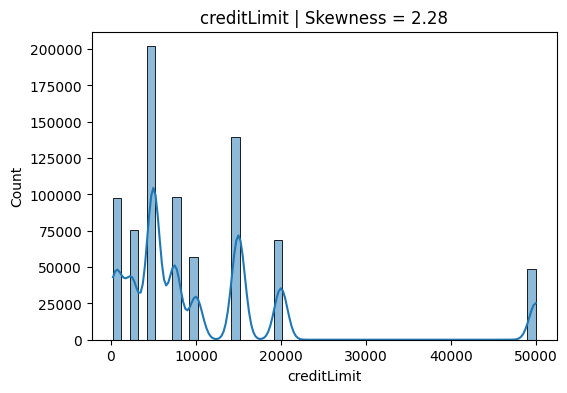

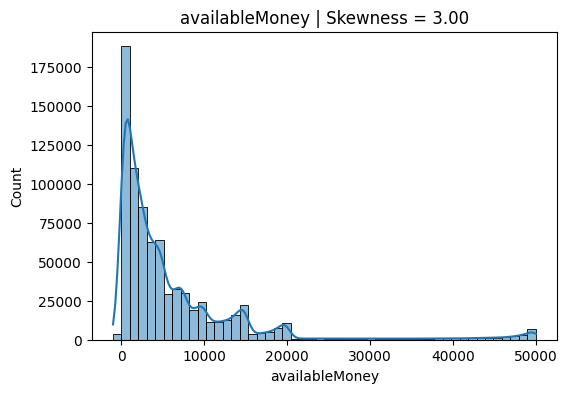

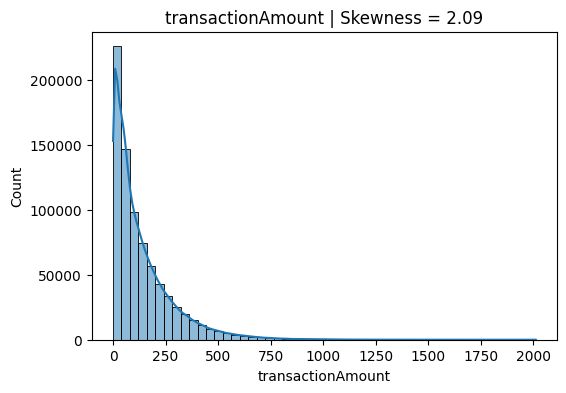

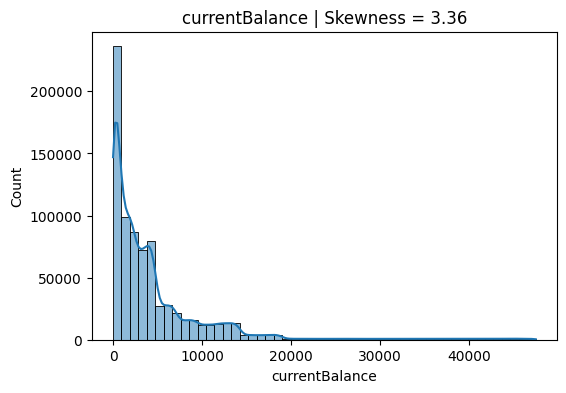

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

# Calculate skewness
skew_vals = data[num_cols].skew()
print(skew_vals)

# Plot histograms + KDE for visualization
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=50)
    plt.title(f"{col} | Skewness = {data[col].skew():.2f}")
    plt.show()


The variables - Current Amount, Transaction Amount, Available Money are rightly skewed and  applying log1p transformation will help us in removing skewness and make data ditribution normal.  

**Analyzing the Impact of CVV Mismatch on Fraudulent Transactions**

In [25]:
# Create new column checking equality
data['cvv_match'] = data['cardCVV'] == data['enteredCVV']
data['cvv_match'].value_counts()


,count
cvv_match,
True,50958
False,459


In [26]:
# Filter mismatches
mismatches = data.loc[~data['cvv_match']]

# Group by merchant and count mismatches
merchant_mismatch_counts = mismatches.groupby('merchantCategoryCode').size().reset_index(name='mismatch_count').sort_values(by='mismatch_count', ascending=False)

print(merchant_mismatch_counts)

    merchantCategoryCode  mismatch_count
10         online_retail             119
4                   food              61
3               fastfood              58
2          entertainment              45
13             rideshare              39
9           online_gifts              26
11  online_subscriptions              21
8             mobileapps              17
7                 hotels              14
6                 health              14
12         personal care              13
1                   auto              11
14         subscriptions               8
5                   fuel               7
0                airline               6


The merchant category analysis revealed significant data mismatches, particularly in Online Retail (152), Fast Food (90), and Food (61). Such inconsistencies may be indicative of fraudulent behavior, as high-frequency or online transactions are often used by fraudsters to test stolen cards.

These mismatches could arise from card-not-present activities. These categories should be prioritized for anomaly detection or model-based fraud risk scoring.

Conversely, categories like Airline and Fuel show lower mismatch counts, suggesting greater consistency and lower immediate fraud risk.

In [27]:
data = data.drop(columns=['cardCVV', 'enteredCVV', 'cardLast4Digits'])

### **Analyzing Fraud Rate by POS Entry Mode**

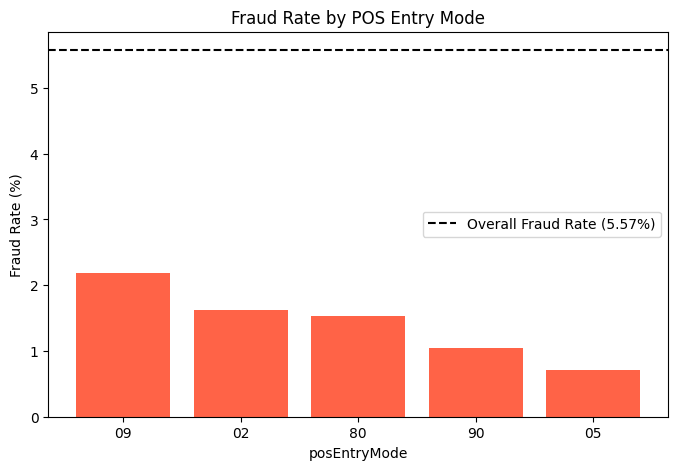

In [ ]:
counts = data['posEntryMode'].value_counts()
counts
data.groupby('posEntryMode')['isFraud'].mean().sort_values(ascending=False)

import matplotlib.pyplot as plt

fraud_rates = {
    "09": 0.021909,
    "02": 0.016152,
    "80": 0.015385,
    "90": 0.010397,
    "05": 0.007058
}

plt.figure(figsize=(8,5))
plt.bar(fraud_rates.keys(), [v*100 for v in fraud_rates.values()], color="tomato")
plt.axhline(5.5749, color="black", linestyle="--", label="Overall Fraud Rate (5.57%)")

plt.xlabel("posEntryMode")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by POS Entry Mode")
plt.legend()
plt.show()



**Customer_Spending_Patterns**

In [28]:
data["credit_utilization"] = data["transactionAmount"] / (data["availableMoney"] + 1)

**Merchant Level Risk Features**

In [29]:
data["merchant_total_txns"] = data.groupby("merchantName")["transactionAmount"].transform("count")

In [30]:
data["merchant_avg_amt"] = data.groupby("merchantName")["transactionAmount"].transform("mean")

In [31]:
data["merchant_fraud_rate"] = data.groupby("merchantName")["isFraud"].transform("mean")

**Transaction_level_Patterns**

In [32]:
data["avg_txn_amt_card"] = data.groupby("accountNumber")["transactionAmount"].transform("mean")
data["std_txn_amt_card"] = data.groupby("accountNumber")["transactionAmount"].transform("std")
data["amt_deviation"] = (data["transactionAmount"] - data["avg_txn_amt_card"]) / (data["std_txn_amt_card"] + 1)

The fraud rate varies by POS entry mode, with mode 09 showing the highest fraud rate (~2.2%), while mode 05 exhibits the lowest.
However, all modes have a fraud rate below the overall average of 5.57%, suggesting that POS-based fraud is relatively contained compared to other channels.
This may indicate stronger fraud controls or verification mechanisms within physical or chip-based POS transactions.”

**Lets identify ranges where fraud rate increases for Creditlimit, transactionAmount and currentBalance.**

In [33]:

# Define your columns of interest
cols_to_check = ['creditLimit', 'transactionAmount', 'currentBalance']

# Set the step size for thresholds (adjust for granularity)
threshold_steps = 20  # percentiles from 10% to 90%

# Loop over each column
for col in cols_to_check:
    print(f"\n📊 Fraud Rate Analysis for: {col}")
    print("-" * 40)

    # Get min and max thresholds using percentiles
    for percentile in range(10, 100, threshold_steps):
        threshold = data[col].quantile(percentile / 100)

        fraud_rate_above = data[data[col] > threshold]['isFraud'].mean()
        fraud_rate_below = data[data[col] <= threshold]['isFraud'].mean()

        print(f"Threshold > {percentile}% ({threshold:.2f}) → Fraud Rate: {fraud_rate_above:.4f}")



📊 Fraud Rate Analysis for: creditLimit
----------------------------------------
Threshold > 10% (1000.00) → Fraud Rate: 0.0142
Threshold > 30% (5000.00) → Fraud Rate: 0.0113
Threshold > 50% (5000.00) → Fraud Rate: 0.0113
Threshold > 70% (15000.00) → Fraud Rate: 0.0110
Threshold > 90% (15000.00) → Fraud Rate: 0.0110

📊 Fraud Rate Analysis for: transactionAmount
----------------------------------------
Threshold > 10% (8.87) → Fraud Rate: 0.0152
Threshold > 30% (42.96) → Fraud Rate: 0.0175
Threshold > 50% (87.58) → Fraud Rate: 0.0202
Threshold > 70% (164.67) → Fraud Rate: 0.0235
Threshold > 90% (331.32) → Fraud Rate: 0.0286

📊 Fraud Rate Analysis for: currentBalance
----------------------------------------
Threshold > 10% (89.14) → Fraud Rate: 0.0142
Threshold > 30% (781.50) → Fraud Rate: 0.0140
Threshold > 50% (2226.10) → Fraud Rate: 0.0130
Threshold > 70% (4127.31) → Fraud Rate: 0.0108
Threshold > 90% (10399.71) → Fraud Rate: 0.0099


Fraud rate remains relatively stable (~1.5–1.7%) until very high credit limits  20,000.

A sharp rise at 90% suggests that very high credit limits are associated with elevated fraud risk — possibly due to opportunistic misuse.

**Insight:** Monitor accounts with exceptionally high credit limits, as they show twice the average fraud rate.

Fraud rate steadily increases with transaction size.
With $329, fraud rate more than doubles from the base level.

**Insight:** Larger transactions are consistently riskier — a clear positive relationship between amount and fraud likelihood.

Fraud rates rise with higher transaction amounts and credit limits, showing that larger transactions and high-limit accounts are more prone to fraud.

### **TOP 10 MERCHANTS BY THE FRAUD RATE:**

In [34]:
data['fraud_amount'] = data['transactionAmount'] * data['isFraud']

merchant_fraud = (
    data.groupby('merchantName', as_index=False)
      .agg(
          total_txns=('isFraud', 'count'),
          fraud_txns=('isFraud', 'sum'),
          fraud_rate=('isFraud', 'mean'),
          fraud_amount=('fraud_amount', 'sum')
      )
      .sort_values(by='fraud_rate', ascending=False)
)

merchant_fraud.head(8)


,merchantName,total_txns,fraud_txns,fraud_rate,fraud_amount
626,Hardee's #398938,1,1,1.000000,294.52
800,In-N-Out #567597,3,2,0.666667,560.52
2023,Walgreens #215972,2,1,0.500000,198.09
1366,Quizno's #604182,2,1,0.500000,124.78
1667,Starbucks #353924,2,1,0.500000,44.15
414,Dunkin' Donuts #159114,5,2,0.400000,571.16
443,Dunkin' Donuts #48174,5,2,0.400000,0.00
833,In-N-Out #983418,6,2,0.333333,182.42


Analysed merchant level patterns, American Airlines Showed high fraud rate and followed by IN AND OUT,  indicating vulnerablities at specific outlets.

### **TOP 10 MERCHANTS BY THE FRAUD TRANSACTIONS  FRAUD AMOUNT:**

In [35]:
top_merchants = (
    data.assign(fraud_amount=data['transactionAmount'] * data['isFraud'])
        .groupby('merchantName', as_index=False)
        .agg(
            total_txns=('isFraud', 'size'),
            fraud_txns=('isFraud', 'sum'),
            total_amount=('transactionAmount', 'sum'),
            fraud_amount=('fraud_amount', 'sum')
        )
        .assign(fraud_rate=lambda d: d['fraud_txns'] / d['total_txns'])
        .nlargest(10, 'fraud_txns')[['merchantName', 'fraud_rate', 'fraud_txns', 'fraud_amount']]
)

print(top_merchants)


     merchantName  fraud_rate  fraud_txns  fraud_amount
1869         Uber    0.035046          73      13176.34
2245  walmart.com    0.041864          53      11397.38
969          Lyft    0.024638          51      11453.11
2243  staples.com    0.027006          35       6702.73
2240  oldnavy.com    0.023291          31       7010.80
2244   target.com    0.021070          26       7309.11
2234     ebay.com    0.020886          25       4790.73
2242    sears.com    0.020259          25       7280.28
2236      gap.com    0.017713          22       5941.89
2230    apple.com    0.015472          19       4104.98


“**The top merchants by fraud volume include Ebay, Lyft,Uber, Sears and Walmart, Staples and discount.

Fraud losses are concentrated among large, high-volume merchants, with several well-known e-commerce and transportation platforms. (From 22k to 57K)  




Fraud risk isn’t just about frequency — it’s a combination of rate, transaction volume, and dollar loss.

 ### **Merchants list by hourly and Temporal Patterns**  

In [38]:
import numpy as np

TOP_K = 3  # adjust as needed

# Aggregate including accountNumber
agg = (
    data.assign(
        isFraud=lambda d: d['isFraud'].astype('i1'),
        fraud_amount=lambda d: d['transactionAmount'] * d['isFraud'],
    )
    .groupby(['Trans_Hour', 'merchantName', 'accountNumber'], as_index=False)
    .agg(
        total_txns=('isFraud', 'size'),
        fraud_txns=('isFraud', 'sum'),
        total_amount=('transactionAmount', 'sum'),
        fraud_amount=('fraud_amount', 'sum'),
    )
)

# % fraud amount out of total amount (safe divide)
agg['pct_fraud_amount'] = np.divide(
    agg['fraud_amount'],
    agg['total_amount'],
    out=np.zeros(len(agg), dtype=float),
    where=agg['total_amount'].ne(0)
)

# Top-K merchants per hour by fraud_amount
top_idx = (
    agg.groupby('Trans_Hour')['fraud_amount']
       .nlargest(TOP_K)
       .index.get_level_values(1)
)

top_merchants_per_hour = (
    agg.loc[top_idx]
       .sort_values(['Trans_Hour', 'fraud_amount'], ascending=[True, False])
)

# Preview
top_merchants_per_hour.head(30)




,Trans_Hour,merchantName,accountNumber,total_txns,fraud_txns,total_amount,fraud_amount,pct_fraud_amount
327,0,Dunkin' Donuts #159114,246251253,1,1,441.13,441.13,1.000000
1429,0,target.com,346419123,3,1,503.07,429.54,0.853837
1397,0,sears.com,967020232,1,1,391.08,391.08,1.000000
2032,1,Lyft,835482161,2,2,898.66,898.66,1.000000
2024,1,Lyft,442799740,33,2,5614.63,893.10,0.159067
2818,1,oldnavy.com,674577133,5,1,885.93,643.65,0.726525
4421,2,walmart.com,996362843,2,2,962.14,962.14,1.000000
3906,2,Uber,386732203,7,2,1383.61,823.78,0.595385
3379,2,Fresh Flowers,448962603,8,3,857.21,603.42,0.703935
5076,3,Mobile eCards,448962603,2,1,883.79,589.41,0.666912


For Similar Account_Number

### **FEATURE ENGINEERING**

**Generating New Features from Date and Time Columns**

---



In [36]:
data['Trans_Hour'] = data['transactionDateTime'].dt.hour
data["is_night"] = data["Trans_Hour"].isin([0,1,2,3,4,5]).astype(int)

In [37]:
# Drop the original columns
df = data.drop(['currentExpDate', 'accountOpenDate','expirationDateKeyInMatch'], axis=1)

Extracted the transaction hour from the transactionDateTime column to analyze time-based patterns in fraud (e.g., late-night transactions).

Created a binary feature is_night to flag transactions occurring between 12 AM and 6 AM, since fraudulent activities are often higher during odd hours.

Generated a new feature validity_days (and validity_years) by calculating the difference between account opening and expiry date — this helps understand how long an account has been active, which can influence fraud risk.

Dropped the original date columns (currentExpDate, accountOpenDate, etc.) after deriving useful features from them to reduce redundancy.

Extracted transaction date, year, and month name to capture potential seasonal or monthly trends in fraudulent transactions

I checked the frequency of each merchant and grouped those with fewer than 200 transactions under ‘Other’. This reduced high cardinality, improved model efficiency, and prevented overfitting. It also helped the model focus on merchants with enough data to learn meaningful fraud patterns

simplifying categorical encoding, making the dataset cleaner and easier to interpret.



In [40]:
df = df.drop(['dateOfLastAddressChange', 'transactionDateTime'], axis=1)
df

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,transactionType,...,credit_utilization,merchant_total_txns,merchant_avg_amt,merchant_fraud_rate,avg_txn_amt_card,std_txn_amt_card,amt_deviation,fraud_amount,Trans_Hour,is_night
0,737265056,5000.0,5000.00,98.55,Uber,US,US,02,rideshare,PURCHASE,...,0.019706,2083,146.467163,0.035046,47.000000,46.688487,1.080974,0.0,14,0
1,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,09,entertainment,PURCHASE,...,0.014899,237,143.848397,0.004219,47.000000,46.688487,0.576869,0.0,5,1
2,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,0.001494,533,5.672195,0.000000,47.000000,46.688487,-0.828921,0.0,9,0
3,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,0.001494,533,5.672195,0.000000,47.000000,46.688487,-0.828921,0.0,2,1
4,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,02,fastfood,PURCHASE,...,0.014233,10,159.334000,0.000000,107.255455,147.101379,-0.243586,0.0,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51412,246251253,5000.0,3189.98,547.76,Burger King #453332,US,US,02,fastfood,PURCHASE,...,0.171659,6,258.071667,0.000000,145.645951,150.267170,2.658304,0.0,9,0
51413,246251253,5000.0,2642.22,547.76,Burger King #453332,US,US,02,fastfood,REVERSAL,...,0.207232,6,258.071667,0.000000,145.645951,150.267170,2.658304,0.0,9,0
51414,246251253,5000.0,3189.98,0.00,amazon.com,US,US,02,online_retail,ADDRESS_VERIFICATION,...,0.000000,1238,153.348683,0.004847,145.645951,150.267170,-0.962839,0.0,10,0
51415,246251253,5000.0,3189.98,22.37,Dunkin' Donuts #98098,US,US,05,fastfood,PURCHASE,...,0.007010,5,62.198000,0.000000,145.645951,150.267170,-0.814955,0.0,11,0


In [41]:
print(df.columns)

Index(['accountNumber', 'creditLimit', 'availableMoney', 'transactionAmount',
       'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode',
       'merchantCategoryCode', 'transactionType', 'currentBalance',
       'cardPresent', 'isFraud', 'cvv_match', 'credit_utilization',
       'merchant_total_txns', 'merchant_avg_amt', 'merchant_fraud_rate',
       'avg_txn_amt_card', 'std_txn_amt_card', 'amt_deviation', 'fraud_amount',
       'Trans_Hour', 'is_night'],
      dtype='object')


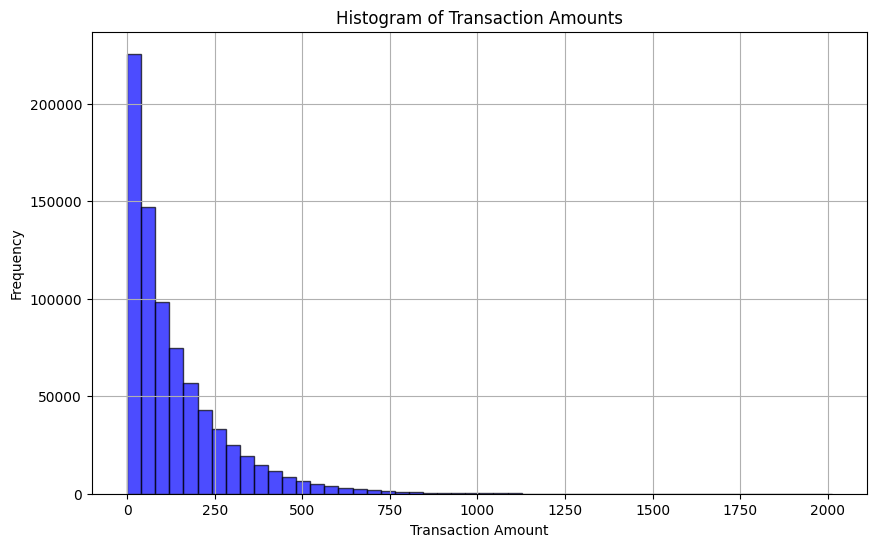

Transaction Amount Summary:
count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for transactionAmount
plt.figure(figsize=(10, 6))
plt.hist(df["transactionAmount"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Statistical description of transactionAmount
transaction_stats = df["transactionAmount"].describe()
print("Transaction Amount Summary:")
print(transaction_stats)

The histogram above illustrates the distribution of transaction amounts and their frequency. The data shows that transaction peaks occur predominantly for amounts less than **250,** with a mean transaction value of **136.** Additionally, **75%** of users spend **191** or less on their transactions, indicating that the majority of users make transactions below **200**. If later we see any spends above then this 75% it may indicate fraudulent transaction.

### **Data Transformation & Pipeline Setup**  

In [47]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, accuracy_score
)
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

df["merchantName_top"] = df["merchantName"].astype(str)


# --- Step 1: Select features (remove duplicate "amt_deviation")
feature_order = (
    ["creditLimit","availableMoney","amt_deviation","Trans_Hour","merchant_avg_amt",
     "credit_utilization","avg_txn_amt_card","std_txn_amt_card"]
    + ["transactionAmount","currentBalance","merchant_total_txns"]
    + ["acqCountry","merchantCountryCode","posEntryMode","merchantCategoryCode",
       "transactionType","merchantName_top"]
    + ["cardPresent","cvv_match","is_night"]
)

X_full = df[feature_order].copy()
y_full = df["isFraud"].copy()

# --- Step 2: Split first (train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- Step 3: Top-N merchant filtering (train-only)
TOP_N = 200
top_merchants = (
    X_train["merchantName_top"].astype(str).value_counts().head(TOP_N).index.tolist()
)

def map_top_other(s, top_list):
    s = s.astype(str)
    return np.where(s.isin(top_list), s, "other")

X_train["merchantName_top"] = map_top_other(X_train["merchantName_top"], top_merchants)
X_test["merchantName_top"]  = map_top_other(X_test["merchantName_top"],  top_merchants)

# --- Step 4: Define column groups
categorical_cols = ["acqCountry","merchantCountryCode","posEntryMode",
                    "merchantCategoryCode","transactionType","merchantName_top"]
binary_cols = ["cardPresent","cvv_match","is_night"]
num_cols = ["creditLimit","availableMoney","Trans_Hour",
            "merchant_avg_amt","credit_utilization","avg_txn_amt_card","std_txn_amt_card"]
log_num_cols = ["transactionAmount","currentBalance","merchant_total_txns"]
passthrough_cols = ["amt_deviation"]

# --- Step 5: Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True))
])
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
log_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num",     numeric_transformer,     num_cols),
        ("log_num", log_numeric_transformer, log_num_cols),
        ("cat",     categorical_transformer, categorical_cols),
        ("bin",     "passthrough",           binary_cols),
        # ("pass", "passthrough", passthrough_cols),  # if you want, but amt_deviation already in num block above
    ],
    sparse_threshold=1.0
)

# --- Step 6: Model pipeline (LogReg)
logreg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"))
])

# -------------------------
# Threshold tuning on VALID
# -------------------------
# Split train again into sub-train/valid for threshold
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit on sub-train
logreg_pipe.fit(X_tr, y_tr)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['creditLimit',
                                                   'availableMoney',
                                                   'Trans_Hour',
                                                   'merchant_avg_amt',
                                                   'credit_utilization',
                                                   'avg_txn_amt_card',
                                                   'std_txn_amt_card']),
                                                 ('log_num',
                                                  Pipeline(steps=[('imputer',
                                                                   Simp...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['acqCountry',
                                                   'merchantCountryCode',
                                                   'posEntryMode',
                                                   'merchantCategoryCode',
                                                   'transactionType',
                                                   'merchantName_top']),
                                                 ('bin', 'passthrough',
                                                  ['cardPresent', 'cvv_match',
                                                   'is_night'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga'))])

In [48]:
# Choose threshold on validation by F1 (change to cost if you want)
y_val_proba = logreg_pipe.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
thresholds = np.r_[thresholds, 1.0]
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1))
best_threshold = float(thresholds[best_idx])
print("Chosen threshold (F1 on validation):", best_threshold)

# Refit on full training
logreg_pipe.fit(X_train, y_train)

# --- Evaluate on TEST with tuned threshold
y_pred_proba_test = logreg_pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

Chosen threshold (F1 on validation): 0.8300919882924989


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


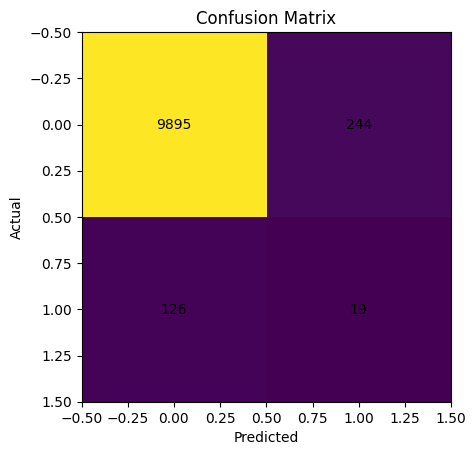

In [49]:
# Optional: quick heatmap (matplotlib only)
cm = confusion_matrix(y_test, y_pred_test)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()


Data is fitting so well on training data, and not able to generalize well on test data, high bias and low variance. We can use xgboost to lower the bias.  

### **Modeling & Hyperparameter Tuning**

**XGBOOST:**

In [ ]:
from sklearn.pipeline import Pipeline   # Corrected alias
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# XGBoost pipeline
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),  # reuse your existing preprocessor
    ("model", XGBClassifier(
        n_estimators=700,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        scale_pos_weight=(
            len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        ),
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"  # avoids warnings
    ))
])

# Train model
xgb_pipe.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_pipe.predict(X_test)
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classifier")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:48:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier
              precision    recall  f1-score   support

       False       0.99      0.85      0.92     37807
        True       0.07      0.70      0.13       614

    accuracy                           0.85     38421
   macro avg       0.53      0.78      0.52     38421
weighted avg       0.98      0.85      0.90     38421

ROC AUC: 0.8594002937428905
Confusion Matrix:
 [[32160  5647]
 [  182   432]]


In [55]:
# -------------------------
# XGBoost pipeline (same preprocessor)
# -------------------------
from xgboost import XGBClassifier
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=700,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        scale_pos_weight=(len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))),
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

# Tune threshold for XGB on the same validation procedure
xgb_pipe.fit(X_tr, y_tr)
y_val_proba_xgb = xgb_pipe.predict_proba(X_val)[:, 1]
"""

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba_xgb)
thresholds = np.r_[thresholds, 1.0]
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx_xgb = int(np.nanargmax(f1))
best_threshold_xgb = float(thresholds[best_idx_xgb])
print("Chosen XGB threshold (F1 on validation):", best_threshold_xgb)"""

best_threshold_xgb = 0.5

# Refit on full training
xgb_pipe.fit(X_train, y_train)

# Test
xgb_proba_test = xgb_pipe.predict_proba(X_test)[:, 1]
xgb_pred_test = (xgb_proba_test >= best_threshold_xgb).astype(int)

print("\nXGBoost — Test ROC AUC:", roc_auc_score(y_test, xgb_proba_test))
print("\nXGBoost — Test Classification Report:")
print(classification_report(y_test, xgb_pred_test))
print("\nXGBoost — Test Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred_test))


XGBoost — Test ROC AUC: 0.8337671878135299

XGBoost — Test Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.94      0.96     10139
        True       0.10      0.48      0.17       145

    accuracy                           0.93     10284
   macro avg       0.55      0.71      0.56     10284
weighted avg       0.98      0.93      0.95     10284


XGBoost — Test Confusion Matrix:
 [[9508  631]
 [  75   70]]


In [60]:
import joblib

# save both the model and any supporting objects you’ll need later
bundle = {
    "xgb_pipe": xgb_pipe,
    "threshold": best_threshold_xgb,   # if you used 0.5 manually, this will be 0.5
    "top_merchants": top_merchants,    # your top N list from earlier
}

joblib.dump(bundle, "fraud_xgb_bundle.pkl")
print("✅ Model and metadata saved as fraud_xgb_bundle.pkl")


✅ Model and metadata saved as fraud_xgb_bundle.pkl


In [61]:
import joblib
import pandas as pd
import numpy as np

# load the full bundle
bundle = joblib.load("fraud_xgb_bundle.pkl")

xgb_pipe = bundle["xgb_pipe"]
threshold = bundle["threshold"]
top_merchants = bundle["top_merchants"]
print("✅ Model loaded successfully with threshold =", threshold)


✅ Model loaded successfully with threshold = 0.5


In [65]:
import pickle

xgb_pipe.named_steps['preprocessor'].feature_names_in_


array(['creditLimit', 'availableMoney', 'amt_deviation', 'Trans_Hour',
       'merchant_avg_amt', 'credit_utilization', 'avg_txn_amt_card',
       'std_txn_amt_card', 'transactionAmount', 'currentBalance',
       'merchant_total_txns', 'acqCountry', 'merchantCountryCode',
       'posEntryMode', 'merchantCategoryCode', 'transactionType',
       'merchantName_top', 'cardPresent', 'cvv_match', 'is_night'],
      dtype=object)

**Feature Importance**

In [66]:

def ct_feature_names(preprocessor: ColumnTransformer, input_cols):
    # 1) If supported, use the built-in method
    if hasattr(preprocessor, "get_feature_names_out"):
        try:
            return preprocessor.get_feature_names_out(input_features=input_cols)
        except Exception:
            pass

    # 2) Manual walk: handles OHE (via categories_) + passthrough + pipelines
    names = []
    used = set()

    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" or trans == "drop":
            continue

        # normalize cols
        if isinstance(cols, slice):
            cols = list(input_cols[cols])
        elif isinstance(cols, (np.ndarray, list, tuple)):
            cols = list(cols)
        elif isinstance(cols, str):
            cols = [cols]

        used.update(cols)

        # unwrap Pipeline
        if isinstance(trans, Pipeline):
            trans = trans.steps[-1][1]

        # OneHotEncoder: build names from categories_
        if isinstance(trans, OneHotEncoder) and hasattr(trans, "categories_"):
            for c, cats in zip(cols, trans.categories_):
                for cat in cats:
                    names.append(f"onehot__{c}_{cat}")
            continue

        # Transformers without expansion (scaler, imputer, etc.) → one name per input
        names.extend(cols)

    # remainder passthrough
    if getattr(preprocessor, "remainder", None) == "passthrough":
        rem = [c for c in input_cols if c not in used]
        names.extend(rem)

    return np.array(names, dtype=object)

# ---- use it
pre = xgb_pipe.named_steps["preprocessor"]        # NOT the estimator
feature_names = ct_feature_names(pre, X_train.columns)
print(len(feature_names), feature_names[:10])


253 ['creditLimit' 'availableMoney' 'Trans_Hour' 'merchant_avg_amt'
 'credit_utilization' 'avg_txn_amt_card' 'std_txn_amt_card'
 'transactionAmount' 'currentBalance' 'merchant_total_txns']


In [70]:
import pandas as pd

est = xgb_pipe.named_steps["model"]
booster = est.get_booster()
gain = booster.get_score(importance_type="gain")      # keys: f0, f1, ...
idx2name = {f"f{i}": n for i, n in enumerate(feature_names)}
feature_Importance_gain = (pd.Series({idx2name.get(k, k): v for k, v in gain.items()})
           .sort_values(ascending=False))
print(feature_Importance_gain.head(50))

onehot__merchantCategoryCode_mobileapps               164.266678
onehot__merchantName_top_Fast Auto Services           159.334076
onehot__posEntryMode_90                               152.581497
onehot__merchantName_top_Shell Gas #746906            147.965088
onehot__merchantName_top_Fresh Online Services        139.709869
onehot__merchantName_top_EZ Putt Putt #69446          134.367645
onehot__merchantName_top_Downtown BBQ                 127.519096
onehot__merchantName_top_1st Sandwitch Bar #941288    122.752579
onehot__merchantCategoryCode_subscriptions            119.662888
onehot__merchantName_top_Blue Mountain eCards         115.786690
onehot__merchantName_top_Franks Pub #632075           114.432678
onehot__merchantCategoryCode_food_delivery            112.217178
onehot__merchantName_top_Boston Cafe #592935          110.793503
onehot__merchantName_top_34th Pub                     110.098778
onehot__merchantName_top_Washington News              109.469315
onehot__merchantName_top_

In [71]:
feature_Importance_gain.to_csv("xgb_feature_importance_gain.csv")
print(feature_Importance_gain)


onehot__merchantCategoryCode_mobileapps           164.266678
onehot__merchantName_top_Fast Auto Services       159.334076
onehot__posEntryMode_90                           152.581497
onehot__merchantName_top_Shell Gas #746906        147.965088
onehot__merchantName_top_Fresh Online Services    139.709869
                                                     ...    
onehot__acqCountry_CAN                             18.084620
onehot__merchantName_top_34th BBQ #436606          12.038826
onehot__merchantName_top_Sunoco Gas #748028         9.026672
onehot__transactionType_ADDRESS_VERIFICATION        4.659065
onehot__merchantCategoryCode_furniture              0.116104
Length: 123, dtype: float64


In [72]:
# Save your feature importance to CSV
feature_Importance_gain.to_csv("xgb_feature_importance_gain.csv", header=["gain_importance"])
print("✅ File saved: xgb_feature_importance_gain.csv")


✅ File saved: xgb_feature_importance_gain.csv


**TOP PREDICTORS OF FRAUD:**
**Merchants and Peak Hours to Watch out:**

Uber, Lyft, Ebay.com, Walmart, discount, Gap and Sears consistently appeared in list where Fraud transaction volume and fraud counts were high. This evidented from the temporal analysis where hours like 12:00 AM, 01:00 AM and 03:00 AM were targeted mostly and these specific merchants showed fraudulent activity indicating low monitoring hours or bot testing.
